In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            precision_recall_curve, average_precision_score)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN
from tensorflow.keras import regularizers
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
# Load and clean data
data = pd.read_csv('/content/drive/MyDrive/loan_data.csv')
print(f"Original shape: {data.shape}")
data.head()

Original shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<ipython-input-5-e6441dac839f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TARGET', data=data, palette='Set2')


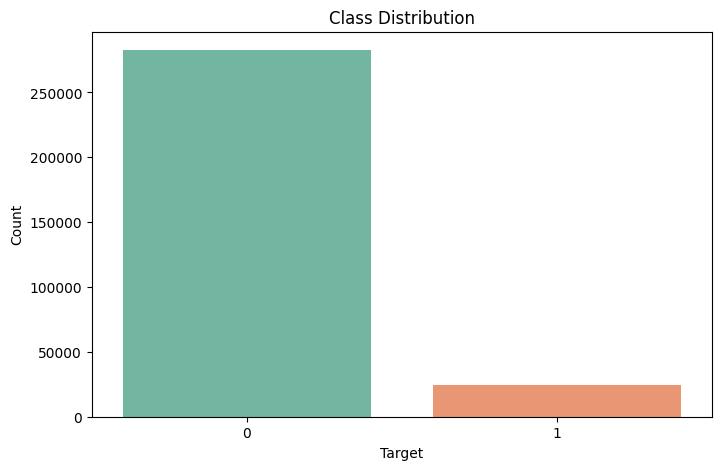

In [ ]:
# Target distribution analysis
plt.figure(figsize=(8,5))
sns.countplot(x='TARGET', data=data, palette='Set2')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Missing value analysis
missing = data.isnull().sum()
print("\nMissing values per column:")
print(missing[missing > 0])


Missing values per column:
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 67, dtype: int64


In [ ]:
# Numerical Columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()
num_imputer = SimpleImputer(strategy='median')
data[num_cols] = num_imputer.fit_transform(data[num_cols])

In [ ]:
# Categorical columns
cat_cols = data.select_dtypes(include='object').columns.tolist()

# One-hot encode categorical features
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

In [ ]:
def prepare_data(data):
    # Advanced feature engineering
    data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['EXT_SOURCE_PROD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].prod(axis=1)
    data['EMPLOYMENT_AGE_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

    # Polynomial features
    data['CREDIT_INCOME_SQ'] = data['CREDIT_INCOME_PERCENT'] ** 2
    return data

data = prepare_data(data)

In [ ]:
def feature_selection_pipeline(X_train, y_train):
    selector = make_pipeline(
        VarianceThreshold(threshold=0.05),  # Remove low-variance features
        SelectFromModel(
            BalancedRandomForestClassifier(
                n_estimators=150,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            ),
            max_features=60  # Select top 60 features
        )
    )
    X_train_selected = selector.fit_transform(X_train, y_train)
    return selector, X_train_selected

In [ ]:
# Split data
X = data.drop('TARGET', axis=1)
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Feature Selection
selector, X_train_selected = feature_selection_pipeline(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [ ]:
# Resampling
resampler = SMOTEENN(sampling_strategy=0.6, smote=SMOTE(k_neighbors=5))
X_res, y_res = resampler.fit_resample(X_train_selected, y_train)

In [ ]:
#Feature Scaling
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test_selected)

In [ ]:
# Neural Network Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='swish',
                         input_shape=(X_res_scaled.shape[1],), # Correct parenthesis placement
                         kernel_regularizer=regularizers.l1_l2(0.0001, 0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation='swish',
                         kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='swish'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Custom Loss with Adaptive Weighting
class AdaptiveLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.95, gamma=4.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        loss = -self.alpha * y_true * tf.math.log(y_pred) - \
               (1-self.alpha) * (1-y_true) * tf.math.log(1-y_pred)

        return tf.reduce_mean(loss * tf.pow(1 - (y_true * y_pred + (1-y_true)*(1-y_pred)), self.gamma))

In [ ]:
# Training Configuration
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00005, weight_decay=0.00001),
    loss=AdaptiveLoss(alpha=0.95, gamma=4.0),
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)

In [ ]:
# Enhanced Training Process
history = model.fit(
    X_res_scaled, y_res,
    validation_split=0.15,
    epochs=200,
    batch_size=1024,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_pr_auc',
            patience=15,
            mode='max',
            restore_best_weights=True
        ),
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 0.00005 * 0.95 ** epoch
        )
    ],
    verbose=1
)

Epoch 1/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.5068 - pr_auc: 0.5223 - precision: 0.5460 - recall: 0.5457 - val_loss: 0.4118 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9975 - learning_rate: 5.0000e-05
Epoch 2/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4156 - pr_auc: 0.5510 - precision: 0.5722 - recall: 0.7094 - val_loss: 0.3693 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9914 - learning_rate: 4.7500e-05
Epoch 3/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3654 - pr_auc: 0.5560 - precision: 0.5692 - recall: 0.8217 - val_loss: 0.3258 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9957 - learning_rate: 4.5125e-05
Epoch 4/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3203 - pr_auc: 0.5651 - precision: 0.5616 - recall: 0.8904 - val_loss: 0.2838 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9987 - learning_rate: 4.2869e-05
Epoch 5/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - los

In [ ]:
# Dual Threshold Optimization
def optimize_threshold(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 100)
    best_gmean = 0
    best_thresh = 0.5

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        gmean = np.sqrt(sensitivity * specificity)

        if gmean > best_gmean:
            best_gmean = gmean
            best_thresh = thresh

    return best_thresh

val_probs = model.predict(X_res_scaled)
optimal_threshold = optimize_threshold(y_res, val_probs)
y_pred = (model.predict(X_test_scaled) >= optimal_threshold).astype(int)

10758/10758 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
# Evaluation
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Optimized Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.67      0.78     56538
         1.0       0.11      0.48      0.18      4965

    accuracy                           0.66     61503
   macro avg       0.53      0.58      0.48     61503
weighted avg       0.87      0.66      0.74     61503


Confusion Matrix:
[[38161 18377]
 [ 2599  2366]]
